In [1]:
import sys
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

# %matplotlib qt

SEED = 0
PATH = '../results/cora/'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Auxiliary functions

In [11]:
def get_best_err(err):
    mean_err = np.mean(err, axis=1)
    std = np.std(err, axis=1)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    best_std = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
            best_std[i, j] = std[i, j, best_epochs_mean[i, j]]

    return best_mean_err, best_std, best_epochs_mean,


def plot_noise_err(err, legend, ylabel):
    fig = plt.figure()
    plt.semilogy(N_P, err, linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Normalized noise power',fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlim([N_P[0], N_P[-1]])
    # plt.ylim([1e-3, 0.2])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    return fig


def print_err(err, std, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f} +- {:.4f}'.format(err[i, j], std[i, j]) 
        print(text)

def plot_iter_err(err, label):
    figs = []
    for i, n_p in enumerate(N_P):
        err_np = err[i]
        figs.append(plt.figure())
        plt.semilogy(err_np.T)
        plt.grid(True, which='both')
        plt.legend(legend)
        plt.title('{}: {}'.format(label, n_p))
        plt.xlim(left=0, right=err.shape[-1])
        plt.tight_layout()
        
    return figs


## Load dataset

Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
Conn Comp: 78


Text(0.5, 1.0, 'Original graph')

<Figure size 432x288 with 0 Axes>

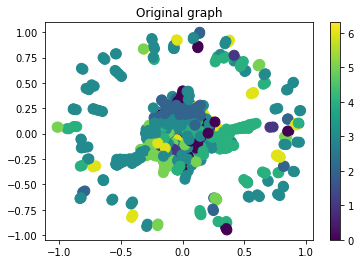

In [3]:
dataset = Planetoid(root='./tmp/Cora', name='Cora')
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')

A = to_dense_adj(data.edge_index).numpy()[0,:,:]
L = np.diag(np.sum(A, axis=0)) - A
lambdas, V = np.linalg.eigh(L)
lambdas = np.real(lambdas)
print('Conn Comp:', np.sum(np.abs(lambdas) <= 1e-6))

labels = data.y

S = A

G = Graph(A)
G.set_coordinates()
plt.figure()
G.plot_signal(labels.numpy())
plt.title('Original graph')


## Binary signals and Bernoulli noise

## Set the expetiments

In [4]:
N_P = [.3, .5]

# Model parameters
epochs =  500
lr = 0.001
loss = nn.MSELoss

Exps = [
        # CVX methods
        {'type': 'BL', 'S': A, 'alpha': .05, 'legend': 'BL'},
        {'type': 'TV', 'A': A, 'alpha': 5, 'legend': 'TV'},        
        {'type': 'LR', 'L': L, 'alpha': 10, 'legend': 'LR'},
        {'type': 'GTF', 'A': A, 'k': 3, 'lamb': .5, 'legend': 'GTF'},

        # Non-convex
        {'type': 'MED', 'S': A, 'legend': 'MED'},
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GAT'},
        # Choose one!
        {'type': 'KronAE', 'fts': 15, 'A': A, 'r': .5, 'last_act': nn.Sigmoid(), 
         'loss': loss(reduction='none'), 'legend': 'K-GAE'},
        {'type': 'KronAE', 'fts': 50, 'A': A, 'r': .5, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': 0, 
         'loss': loss(reduction='none'), 'legend': 'GD'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

# Compute needed matrices
for exp in Exps:
    if exp['type'] == 'DD' and exp['legend'] == 'GD':
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] == 'DD' and exp['legend'] == 'GCG':
        H = utils.create_filter(S, exp['h_params'])
        exp['Us'] =[H]*(len(exp['nodes'])-2) + [None]
        exp['As'] = []


In [5]:
unique_labels = np.unique(labels)

print('Labels:', unique_labels)
n_labels = len(unique_labels)
n_signals = 15

err = np.zeros((len(N_P), n_labels*n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)

    for l, label in enumerate(unique_labels):
        x = np.zeros(G.N)
        x[labels == label] = 1

        for j in range(n_signals):
            idx = l*n_signals + j
            x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)

            for k, exp in enumerate(Exps):
                model = select_model(exp, x_n, epochs, lr, device)

                if type(model) == Model:
                    weights[k] = model.count_params()
                    _, err[i, idx, k], _ = model.fit(x_n, x, class_val=True, device=device)
                else:
                    model.fit(x_n)
                    _, err_non_train = model.test_classification(x)
                    err[i, idx, k] = np.repeat(err_non_train, epochs)

                print('{} ({},{}): err rate: {:.3f} '.format(exp['legend'], l ,j, err[i, idx, k].min()))

            # print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Labels: [0 1 2 3 4 5 6]
Noise: 0.3
BL (0,0): err rate: 0.157 
TV (0,0): err rate: 0.132 
TV (0,0): err rate: 0.131 
LR (0,0): err rate: 0.129 
LR (0,0): err rate: 0.139 
LR (0,0): err rate: 0.143 
K-GAE (0,0): err rate: 0.130 
K-GAE (0,0): err rate: 0.129 
BL (0,1): err rate: 0.153 
TV (0,1): err rate: 0.131 
TV (0,1): err rate: 0.133 
LR (0,1): err rate: 0.112 
LR (0,1): err rate: 0.131 
LR (0,1): err rate: 0.143 
K-GAE (0,1): err rate: 0.125 
K-GAE (0,1): err rate: 0.124 
BL (1,0): err rate: 0.099 
TV (1,0): err rate: 0.077 
TV (1,0): err rate: 0.079 
LR (1,0): err rate: 0.100 
LR (1,0): err rate: 0.097 
LR (1,0): err rate: 0.097 
K-GAE (1,0): err rate: 0.080 
K-GAE (1,0): err rate: 0.080 
BL (1,1): err rate: 0.099 
TV (1,1): err rate: 0.079 
TV (1,1): err rate: 0.079 
LR (1,1): err rate: 0.098 
LR (1,1): err rate: 0.099 
LR (1,1): err rate: 0.099 
K-GAE (1,1): err rate: 0.080 
K-GAE (1,1): err rate: 0.080 
BL (2,0): err rate: 0.145 
TV (2,0): err rate: 0.140 
TV (2,0): err rate: 0.1

KeyboardInterrupt: 

### Plot results

Err Noise: 0.4963072378138848
Err all 0: 0.15731166912850814
N_P: [0.3, 0.5]
BL (0.0): 	0.1354 +- 0.0261	0.2674 +- 0.0161
TV (0.0): 	0.1178 +- 0.0288	0.1299 +- 0.0285
TV (0.0): 	0.1195 +- 0.0292	0.1257 +- 0.0304
LR (0.0): 	0.1076 +- 0.0125	0.5139 +- 0.0244
LR (0.0): 	0.1267 +- 0.0214	0.5241 +- 0.0296
LR (0.0): 	0.1358 +- 0.0285	0.5583 +- 0.0430
K-GAE (526.0): 	0.1157 +- 0.0168	0.1214 +- 0.0309
K-GAE (526.0): 	0.1200 +- 0.0159	0.1213 +- 0.0308

N_P: [0.3, 0.5]
BL (0.0): 	0.1543 +- 0.0562	0.1889 +- 0.1460
TV (0.0): 	0.1429 +- 0.0717	0.1125 +- 0.1043
TV (0.0): 	0.1434 +- 0.0720	0.1097 +- 0.1031
LR (0.0): 	0.1033 +- 0.0277	0.3279 +- 0.2453
LR (0.0): 	0.1189 +- 0.0367	0.3314 +- 0.2487
LR (0.0): 	0.1352 +- 0.0516	0.3430 +- 0.2610
K-GAE (526.0): 	0.1399 +- 0.0318	0.2626 +- 0.1991
K-GAE (526.0): 	0.1372 +- 0.0317	0.2339 +- 0.2050


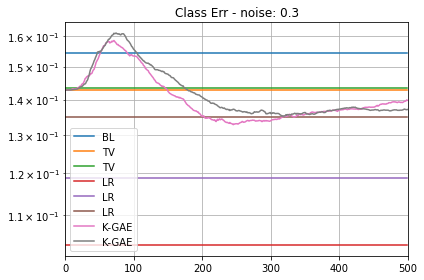

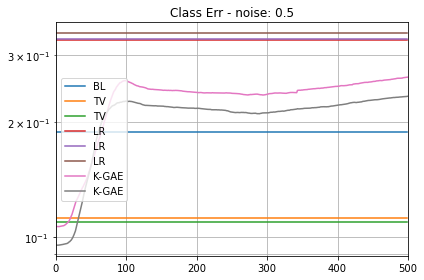

In [12]:
best_mean_err, std, _ = get_best_err(err[:,:6,:,:])
fixed_mean_err = np.mean(err, axis=1)[:, :, -1]
fixed_std = np.std(err, axis=1)[:, :, -1]
# fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error (Best epoch)')
# fig4 = plot_noise_err(fixed_mean_err, legend, 'Mean Error (Last epoch)')

print('Err Noise:', np.sum(np.abs(x-x_n))/x.size)
print('Err all 0:', np.sum(x)/x.size)

print_err(best_mean_err, std, weights)
print()
print_err(fixed_mean_err, fixed_std, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')

## Categorical signals - Gaussian noise

In [ ]:
N_P = [.1, .3]
n_signals = 25
x = labels.numpy()

mse = np.zeros((len(N_P), n_signals, len(Exps), epochs))
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x_n = ds.GraphSignal.add_noise(x, n_p)

        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                mse[i, j, k], err[i, j, k], _ = model.fit(x_n, x, class_val=True, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)


        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

### Plot results

In [ ]:
best_mean_err, std, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, std_mse, _, _ = get_best_err(mse_norm)

# fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
# fig4 = plot_noise_err(best_mean_mse, legend, 'Median Error')

print_err(best_mean_err,std, weights)
print()
print_err(best_mean_mse, std_mse, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')
figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

In [ ]:
# Last Act Funct: None
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

figs = plot_iter_err(np.mean(err[:,:,:4,:], axis=1), 'Class Err - noise')
# figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

In [ ]:
# Last Act Funct: Sigmoig
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

figs = plot_iter_err(np.mean(err[:,:,4:8,:], axis=1), 'Class Err - noise')
# figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

In [ ]:
# Last Act Funct: ReLU
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

figs = plot_iter_err(np.mean(err[:,:,8:,:], axis=1), 'Class Err - noise')
# figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

## Categorical signals - Changing labels

In [ ]:
N_P = [.1, .3]
n_signals = 25

x = labels.numpy()

mse = np.zeros((len(N_P), n_signals, len(Exps), epochs))
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x_n = ds.GraphSignal.change_labels(x, n_p)

        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                mse[i, j, k], err[i, j, k], _ = model.fit(x_n, x, class_val=True, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)


            print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

### Plot results

In [ ]:
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

# fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
# fig4 = plot_noise_err(best_mean_mse, legend, 'Median Error')

print_err(best_mean_err, weights)
print()
print_err(best_mean_mse, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')
figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

## Using signal associtated with label 0 - As Class problem

In [ ]:
# N_P = [.1]
# lr = 0.001
# loss=nn.CrossEntropyLoss
# last_ft = 2
# Exps = [

#         # {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'legend': 'GAT'},
    
#         # [[300, 1000], [400, 1000], [500, 1000], [750, 1000], [1000, 2000], [250, 500, 1500],
#         #       [300, 1000, 2000], [400, 1000, 2000], [500, 1000, 2000]]

#         # With SIGMOID
#         # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [400, 1000] + [G.N]*2, 'fts': [70]*3 + [2],
#         #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
#         #  'loss': loss(reduction='none'), 'legend': 'GD'},


#         # {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 2, 'last_act': None,
#         #  'loss': loss(reduction='none'), 'legend': 'GCNN'},

#         {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': last_ft, 'last_act': nn.ReLU(),
#          'loss': loss(reduction='none'), 'legend': 'GCNN'},
#         {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': last_ft, 'last_act': nn.Sigmoid(),
#          'loss': loss(reduction='none'), 'legend': 'GCNN'},


#         # # CURRENT BEST: GD (7600.0): 	0.0693
#         {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [2],
#          'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': 1, 'bn': False, 'K': None,
#          'gamma': 0, 'loss': loss(reduction='none'), 'legend': 'GD'},
        
#         # GD (7600.0): 	0.0733
#         {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [2],
#          'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': 1, 'bn': False, 'K': None,
#          'gamma': .1, 'loss': loss(reduction='none'), 'legend': 'GD'},



#         ]

# # Model parameters
# epochs =  1000

# legend = [exp['legend'] for _, exp in enumerate(Exps)]

# # Create filter H
# h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
# H = utils.create_filter(S, h_params)
# H_norm = H/np.linalg.norm(H)

# for exp in Exps:
#     # if exp['type'] == '2LD':
#     #     exp['H'] = H_norm if exp['H_norm'] else H
#     # elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MEAN:
#     if exp['type'] == 'DD':
#     #     # clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
#         idx = clts_nodes.index(exp['nodes'])
#         exp['nodes'] = clts[idx].sizes
#         exp['Us'] = clts[idx].Us
#         exp['As'] = clts[idx].As
#     # elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MAT:
#         # exp['Us'] = [H_norm] if exp['H_norm'] else [H]
#         # exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
#         # exp['As'] = []

In [ ]:
# n_signals = 25

# x = np.zeros(G.N)
# x[labels == 0] = 1

# # Good but inverted
# x_1hot = np.zeros((G.N, 2))
# # x_1hot[x == 1, 0] = 1
# # x_1hot[x != 1, 1] = 1

# x_1hot[x != 1, 0] = 1
# x_1hot[x == 1, 1] = 1

# xx_nn = np.zeros((len(N_P), n_signals, G.N))
# cross = np.zeros((len(N_P), n_signals, len(Exps), epochs))
# err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
# weights = np.zeros(len(Exps))
# start_time = time.time()
# for i, n_p in enumerate(N_P):
#     print('Noise:', n_p)
#     for j in range(n_signals):

#         x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)

#         xx_nn[i,j,:] = x_n
#         x_n_1hot = np.zeros((G.N, 2))
#         # x_n_1hot[x_n == 1, 0] = 1
#         # x_n_1hot[x_n != 1, 1] = 1

#         x_n_1hot[x_n != 1, 0] = 1
#         x_n_1hot[x_n == 1, 1] = 1

#         for k, exp in enumerate(Exps):
#             print(exp['legend'], end=' ')
#             # Change arch to use 1hot input?
#             model = select_model(exp, x_n_1hot, epochs, lr, device)

#             if type(model) == Model:
#                 weights[k] = model.count_params()
#                 cross[i, j, k], err[i, j, k], _ = model.fit(x_n_1hot, x_1hot, device=device)
#             else:
#                 model.fit(x_n)
#                 _, err_non_train = model.test(x)
#                 err[i, j, k] = np.repeat(err_non_train, epochs)

#             print('j:', j, 'cross:', cross[i, j, k].min(), 'err rate:', err[i, j, k].min())

#         # print(j, end=' ')
#     print()

# print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

In [ ]:
# best_mean_err, best_med_err, _, _ = get_best_err(err)
# fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
# fig4 = plot_noise_err(best_med_err, legend, 'Median Error')
# # fig3.savefig(PATH + 'denoise_temp_all_pn.eps')
# # fig4.savefig(PATH + 'denoise_temp_all_pn.eps')

# print('Err all 0:', np.sum(x)/x.size)
# print('Err Noise:', np.sum(np.abs(x-x_n))/x.size)

# print_err(best_mean_err, weights)

# best_mean_cross, _, _, _ = get_best_err(cross)
# print_err(best_mean_cross, weights)

# figs = plot_iter_err(np.mean(cross, axis=1), 'Median MSE - noise')
# figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')


In [ ]:
plt.show()